In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
from google.colab import drive
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import math  

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

f = open('/content/drive/MyDrive/4th_Sem/DL/A2/train_set.pkl', 'rb')   
mat = pickle.load(f)         # load file content as mydict
f.close()

f1 = open('/content/drive/MyDrive/4th_Sem/DL/A2/val_set.pkl', 'rb')  
mat1 = pickle.load(f1)         
f1.close()

X = mat['Image']
X_train=np.empty(shape=(10000,28,28),dtype='float')
Y_train = mat['Labels']
for x in range(len(X)):
  X_train[x] = np.asarray(X[x])

X_train = X_train.reshape(10000,784).T/255
print(X_train.shape)
print(Y_train.shape)

X = mat1['Image']
X_val=np.empty(shape=(2000,28,28),dtype='float')
Y_val = mat1['Labels']
for x in range(len(X)):
  X_val[x] = np.asarray(X[x])

X_val = X_val.reshape(2000,784).T/255
print(X_val.shape)
print(Y_val.shape)

(784, 10000)
(10000,)
(784, 2000)
(2000,)


In [ ]:
class activation:
  def __init__(self,func):
    self.func=func

  def forward_activation(self,Z):
    if self.func == 'ReLU':
      return np.maximum(Z, 0)
    elif self.func == 'sigmoid':
      return 1/(1+np.exp(-Z))
    elif self.func == 'tanh':
      return 2/(1+np.exp(-2*Z))-1

  def back_activation(self,Z):
    if self.func == 'ReLU':
      return (Z > 0)
    elif self.func == 'sigmoid':
      return (1/(1+np.exp(-Z)))*(1-1/(1+np.exp(-Z)))
    elif self.func == 'tanh':
      return 1-(2/(1+np.exp(-2*Z))-1)*(2/(1+np.exp(-2*Z))-1)


In [ ]:
class optimize():
  def __init__(self,opt):
    self.opt=opt
    self.vw1=0
    self.vb1=0
    self.vw2=0
    self.vb2=0
    self.Mw1=0
    self.Rw1=0
    self.Mb1=0
    self.Rb1=0
    self.Mw2=0
    self.Rw2=0
    self.Mb2=0
    self.Rb2=0
    self.t=0
    

  def optimizer(self,lr,W1, b1, W2, b2,dW1, db1, dW2, db2):
   
   if (self.opt=='GD'):
      W1 = W1 - lr * dW1
      b1 = b1 - lr * db1    
      W2 = W2 - lr * dW2  
      b2 = b2 - lr * db2  
      return W1,b1,W2,b2

   elif (self.opt=='GDM'):
      gamma = .9
      self.vw1=gamma*self.vw1 - lr*dW1 
      self.vb1=gamma*self.vb1 - lr*db1
      self.vw2=gamma*self.vw2 - lr*dW2
      self.vb2=gamma*self.vb2 - lr*db2
      W1 = W1 + self.vw1
      b1 = b1 + self.vb1
      W2 = W2 + self.vw2
      b2 = b2 + self.vb2
      return W1,b1,W2,b2
    
   elif (self.opt=='NAG'):
      gamma = .9
    
      W1 = W1 + gamma*self.vw1- lr * dW1
      b1 = b1 + gamma*self.vb1- lr * db1
      W2 = W2 + gamma*self.vw2- lr * dW2
      b2 = b2 + gamma*self.vb2- lr * db2
      
      self.vw1=gamma*self.vw1 - lr*dW1 
      self.vb1=gamma*self.vb1 - lr*db1
      self.vw2=gamma*self.vw2 - lr*dW2
      self.vb2=gamma*self.vb2 - lr*db2
      return W1,b1,W2,b2

   elif (self.opt=='adagrad'):
      
      self.vw1+=dW1**2
      self.vb1+=db1**2
      self.vw2+=dW2**2
      self.vb2+=db2**2

      W1= W1 - lr * dW1/(np.sqrt(self.vw1) + 0.00001)
      b1= b1 - lr * db1/(np.sqrt(self.vb1) + 0.00001)    
      W2= W2 - lr * dW2/(np.sqrt(self.vw2) + 0.00001)  
      b2= b2 - lr * db2/(np.sqrt(self.vb2) + 0.00001)  
      return W1,b1,W2,b2

   elif (self.opt=='RMSprop'):
      gamma = .9
      
      self.vw1=gamma*self.vw1+(1-gamma)*(dW1**2)
      self.vb1=gamma*self.vb1+(1-gamma)*(db1**2)
      self.vw2=gamma*self.vw2+(1-gamma)*(dW2**2)
      self.vb2=gamma*self.vb2+(1-gamma)*(db2**2)

      W1= W1 - lr * dW1/(np.sqrt(self.vw1) + 0.0000001)
      b1= b1 - lr * db1/(np.sqrt(self.vb1) + 0.0000001)    
      W2= W2 - lr * dW2/(np.sqrt(self.vw2) + 0.0000001)  
      b2= b2 - lr * db2/(np.sqrt(self.vb2) + 0.0000001)  
      return W1,b1,W2,b2
    
   elif (self.opt=='ADAM'):
      beta1 = .9
      beta2 = .999
      self.t+=1
      
      self.Mw1=beta1*self.Mw1+(1-beta1)*(dW1)/(1. - beta1**(self.t))
      self.Mb1=beta1*self.Mb1+(1-beta1)*(db1)/(1. - beta1**(self.t))
      self.Mw2=beta1*self.Mw2+(1-beta1)*(dW2)/(1. - beta1**(self.t))
      self.Mb2=beta1*self.Mb2+(1-beta1)*(db2)/(1. - beta1**(self.t))

      self.Rw1=beta2*self.Rw1+(1-beta2)*(dW1**2)/(1. - beta2**(self.t))
      self.Rb1=beta2*self.Rb1+(1-beta2)*(db1**2)/(1. - beta2**(self.t))
      self.Rw2=beta2*self.Rw2+(1-beta2)*(dW2**2)/(1. - beta2**(self.t))
      self.Rb2=beta2*self.Rb2+(1-beta2)*(db2**2)/(1. - beta2**(self.t))

      W1= W1 + lr * self.Mw1/(np.sqrt(self.Rw1) + 0.000001)
      b1= b1 + lr * self.Mb1/(np.sqrt(self.Rb1) + 0.000001)    
      W2= W2 + lr * self.Mw2/(np.sqrt(self.Rw2) + 0.000001)  
      b2= b2 + lr * self.Mb2/(np.sqrt(self.Rb2) + 0.000001)  


      return W1,b1,W2,b2





    


In [ ]:
class wt_init():
  def __init__(self,wt_tech):
    self.wt_tech=wt_tech
    self.W1 = np.random.rand(10, 784) - 0.5
    self.b1 = np.random.rand(10, 1) - 0.5
    self.W2 = np.random.rand(10, 10) - 0.5
    self.b2 = np.random.rand(10, 1) - 0.5

  def init_tech(self):

    if (self.wt_tech == 'Xavier'):
      self.W1 = (np.random.rand(10, 784) - 0.5)*1/math.sqrt(784)
      self.b1 = (np.random.rand(10, 1) - 0.5)*1/math.sqrt(784)
      self.W2 = (np.random.rand(10, 10) - 0.5)*1/math.sqrt(10)
      self.b2 = (np.random.rand(10, 1) - 0.5)*1/math.sqrt(10)
      return self.W1, self.b1, self.W2, self.b2

    elif (self.wt_tech == 'He'):
      self.W1 = (np.random.rand(10, 784) - 0.5)*math.sqrt(2/784)
      self.b1 = (np.random.rand(10, 1) - 0.5)*math.sqrt(2/784)
      self.W2 = (np.random.rand(10, 10) - 0.5)*math.sqrt(2/10)
      self.b2 = (np.random.rand(10, 1) - 0.5)*math.sqrt(2/10)
      return self.W1, self.b1, self.W2, self.b2
    
    else :
      return self.W1, self.b1, self.W2, self.b2



In [ ]:
class regularizer():
  def __init__(self,reg):
    self.reg=reg

  def regularizer_method(self,W1,b1,W2,b2):
    if (self.reg=='L1'):
      W1=W1+0.5*np.mean(np.absolute(W1))
      W2=W2+0.5*np.mean(np.absolute(W2))
      b1=b1+0.5*np.mean(np.absolute(b1))
      b2=b2+0.5*np.mean(np.absolute(b2))
      return W1,b1,W2,b2
    
    elif (self.reg=='L2'):
      W1=W1+0.5*np.mean(W1**2)
      b1=b1+0.5*np.mean(b1**2)
      W2=W2+0.5*np.mean(W2**2)
      b2=b2+0.5*np.mean(b2**2)
      return W1,b1,W2,b2
    
    elif (self.reg=='Dropout'):
      W1=np.multiply((np.random.rand(W1.shape[0], W1.shape[1])<0.8),W1)
      b1=np.multiply((np.random.rand(b1.shape[0], b1.shape[1])<0.8),b1)
      W2=np.multiply((np.random.rand(W2.shape[0], W2.shape[1])<0.8),W2)
      b2=np.multiply((np.random.rand(b2.shape[0], b2.shape[1])<0.8),b2)
      return W1,b1,W2,b2

    else :
      return W1,b1,W2,b2


In [ ]:
class MLPClassifier(activation,optimize,wt_init,regularizer):
  
  def __init__(self,lr,epochs,func='ReLU',opt='GD',wt_tech='random',reg='L2'):
    self.X=0
    self.Y=0
    self.lr=lr
    self.epochs=epochs
    activation.__init__(self,func)
    optimize.__init__(self,opt)
    wt_init.__init__(self,wt_tech)
    regularizer.__init__(self,wt_tech)


  
  def softmax(self,Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

  def forward_prop(self,X,W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1
    A1 = self.forward_activation(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = self.softmax(Z2)
    return Z1, A1, Z2, A2


  def backward_prop(self,Z1, A1, Z2, A2, W1, b1, W2, b2,X,Y):
    m=Y.size
    one_hot_Y = label_binarize(Y, classes=[0, 1, 2,3,4,5,6,7,8,9])
    dZ2 = A2 - one_hot_Y.T
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * self.back_activation(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

  def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y = shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

  def dropout(W, keep_proba):
    return np.multiply((np.random.rand(W.shape[0], W.shape[1])<0.8),W)

    


  def fit(self,X1,Y1,X2,Y2):
    X_train=X1
    Y_train=Y1
    X_test=X2
    y_test=Y2


    
    W1, b1, W2, b2 = self.init_tech()
    Train_loss=[]
    Test_loss=[]
    Epochs=[]
    test=[]

    for i in range(self.epochs):
        Z1, A1, Z2, A2 = self.forward_prop(X_train,W1, b1, W2, b2)
        dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, W1, b1, W2, b2,X_train,Y_train)
        W1,b1,W2,b2=self.optimizer(self.lr,W1, b1, W2, b2,dW1, db1, dW2, db2)
        W1,b1,W2,b2=self.regularizer_method(W1,b1,W2,b2)
        _, _, _, Y_pred = self.forward_prop(X_test,W1, b1, W2, b2)

        if i % 10 == 0:
            predictions = np.argmax(A2, 0)
            
            Y_pred= np.argmax(Y_pred, 0)
            Y_pred=np.array(Y_pred)
            y_true=np.array(Y_train)

            acc=np.sum(predictions == Y_train) / Y_train.size
            err_train=mean_squared_error(Y_train, predictions)
            err_test=mean_squared_error(y_test, Y_pred)
            Train_loss.append(err_train)
            Test_loss.append(err_test)
            Epochs.append(i)
            test.append(Y_pred)

    return W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs

  def get_predictions(self,X_train,Y_train,X_test):
    W1, b1, W2, b2,_, _, _, _ = self.fit(X_train,Y_train)
    Z1, A1, Z2, A2 = self.forward_prop(X_train,W1, b1, W2, b2)
    predictions = np.argmax(A2, 0)
    return predictions

  def get_loss(self,X,Y):
    W1, b1, W2, b2,Y_pred,acc,train_loss,test_loss,epochs=self.fit(X,Y)
    return train_loss,test_loss,epochs

  def get_proba(self,X_train,Y_train):
    _,_,_,_,A,_=self.fit(X_train,Y_train)
    return A

  def get_params(self,X_train,Y_train):
    W1, b1, W2, b2 , _,_=self.fit(X_train,Y_train)
    return W1, b1, W2, b2

  def Score(self,X_train,Y_train):
    _, _, _, _ , _,acc=self.fit(X_train,Y_train)
    return acc
    


SGD with ReLU

In [ ]:
model= MLPClassifier(0.1,200,func='ReLU',opt='NAG',wt_tech='He',reg='Dropout')
W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs=model.fit(X_train,Y_train,X_val,Y_val)
print('MLP accuracy With ReLU',acc)

MLP accuracy With ReLU 0.9416


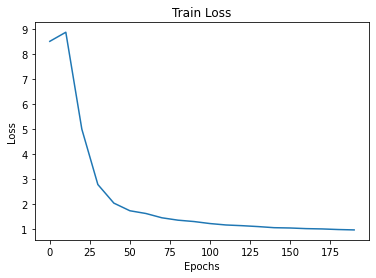

In [ ]:
plt.plot(Epochs,Train_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

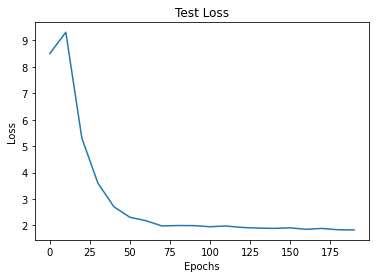

In [ ]:
plt.plot(Epochs,Test_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
confusion_matrix(Y_train, predictions)

Confusion Matrix


array([[984,   0,   2,   1,   3,   1,   1,   3,   5,   0],
       [  0, 978,   4,   3,   2,   5,   0,   0,   6,   2],
       [  3,  11, 916,  13,   9,   8,   7,   6,  20,   7],
       [  2,   7,  23, 901,   2,  35,   1,  10,   8,  11],
       [  1,   5,   6,   0, 945,   0,   8,   1,   7,  27],
       [  8,   4,   5,  29,  10, 908,  12,   1,  18,   5],
       [  5,   2,   3,   0,   4,   7, 972,   1,   5,   1],
       [  3,   6,   9,   4,  10,   0,   0, 954,   1,  13],
       [  4,  14,  10,  15,   7,  12,   9,   1, 919,   9],
       [  6,   1,   1,  12,  13,   1,   0,  22,   5, 939]])

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))